# Classifying MNIST Digits - Reloaded
In this notebook, we will dive deeper into the problem of classifying the digits of the MNIST dataset.

## Preparations
We start with the usual preparations. These are very similar to what you have already seen in the previous notebook.

### Load libraries

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import L1, L2

In [3]:
import pickle

In [4]:
tf.random.set_seed(123)
np.random.seed(123)

### Prepare data

In [5]:
# Load data:
fashion_mnist = tf.keras.datasets.mnist
(train_val_images, train_val_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Scale image data:
train_val_images = train_val_images / 255.0
test_images = test_images / 255.0

# Split into training / validation
train_images_all, val_images, train_labels_all, val_labels = train_test_split(train_val_images, train_val_labels,
                                                                              test_size=0.20, random_state=42)

In [6]:
train_val_label_df = pd.DataFrame(train_val_labels)
train_val_label_df.columns = ['label']
train_val_label_df['label'].value_counts()

label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

In [7]:
val_label_df = pd.DataFrame(val_labels)
val_label_df.columns = ['label']
val_label_df['label'].value_counts(sort=False, ascending=True)

label
7    1299
3    1219
8    1160
9    1194
5    1104
4    1176
2    1174
6    1177
1    1322
0    1175
Name: count, dtype: int64

In [8]:
# randomly choose a given number of data points for training
n_train = 1000

n_train_all = train_images_all.shape[0]
train_indices = np.random.choice(range(n_train_all), n_train)

train_images = train_images_all[train_indices]
train_labels = train_labels_all[train_indices]

In [9]:
# convert to one-hot vector
train_labels_OH = to_categorical(train_labels)
val_labels_OH = to_categorical(val_labels)
test_labels_OH = to_categorical(test_labels)

## Convolutional Neural Network

### Model Definition

In [10]:
mnist_classifier_cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 4 × 4 x 32
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [11]:
mnist_classifier_cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [12]:
mnist_classifier_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        28,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,958 (171.71 KB)

 Trainable params: 43,958 (171.71 KB)

 Non-trainable params: 0 (0.00 B)

### Helper Functions
We use the same helper functions as in the previous notebook:

In [13]:
def plot_history(history, logy=False):
    """
    Plot model training history.
    Args:
    - history: tensorflow history object.

    Returns:
    None
    """
    # plt.subplot(2, 1, 1)
    plt.subplot(311)
    plt.plot(history['loss'], label='Training')
    if 'val_loss' in history.keys():
        plt.plot(history['val_loss'], label='Validation')
    plt.legend()
    plt.ylabel('Loss')
    if logy:
        plt.yscale('log')
    plt.grid()

    plt.subplot(312)
    plt.plot(history['accuracy'], label='Training')
    if 'val_accuracy' in history.keys():
        plt.plot(history['val_accuracy'], label='Validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    if logy:
        plt.yscale('log')
    plt.grid()    

    plt.subplot(313)
    plt.plot([1-acc for acc in history['accuracy']], label='Training')
    if 'val_accuracy' in history.keys():
        plt.plot([1-acc for acc in history['val_accuracy']], label='Validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Error Rate')
    if logy:
        plt.yscale('log')
    plt.grid()

    plt.show()

In [14]:
def train_analyse_model(model, model_name, train_from_scratch, classi_weights_path, classi_history_path, 
                        train_images, train_labels_OH, val_images, val_labels_OH, test_images, test_labels,
                        nEpochs = 100, nPatience = 10):

    # Train model or load pretrained weights:
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    
    if train_from_scratch:
        print('Training quietly')
        history = model.fit(train_images, train_labels_OH, validation_data = (val_images, val_labels_OH),
                                          epochs = nEpochs, verbose = False, 
                                          callbacks = [ EarlyStopping(monitor='val_accuracy', patience=nPatience,
                                                                      verbose=False, restore_best_weights=True)])
        # Save the weights:
        model.save_weights(classi_weights_path)
    
        # Save training history:
        with open(classi_history_path, 'wb') as f:
            pickle.dump(history, f)
    else:
        # load previsously computed weights
        model.load_weights(classi_weights_path)
    
        # load history:
        with open(classi_history_path, 'rb') as f:
            history = pickle.load(f)

    plt.figure(0)
    plot_history(history.history)
    
    # Evaluate accuracy on training data
    train_labels_OH_est = model.predict(train_images)
    train_labels_est = np.argmax(train_labels_OH_est, 1)
    print('\nAccuracy on training data:', accuracy_score(train_labels, train_labels_est))

    # Evaluate accuracy on validation data
    val_labels_OH_est = model.predict(val_images)
    val_labels_est = np.argmax(val_labels_OH_est, 1)
    print('\nAccuracy on validation data:', accuracy_score(val_labels, val_labels_est))

    # Evaluate accuracy on test data
    test_labels_OH_est = model.predict(test_images)
    test_labels_est = np.argmax(test_labels_OH_est, 1)
    print('Accuracy on testdata:', accuracy_score(test_labels, test_labels_est))

    # plot confusion matrix
    plt.figure(1)
    ConfusionMatrixDisplay.from_predictions(test_labels, test_labels_est, normalize='true', values_format='.2f')
    plt.title('Confusion matrix on Test data')
    plt.show()

    # generate dataframe with accuracy on validation and test data
    return pd.DataFrame({'Method': model_name, 
                         'Training': accuracy_score(train_labels, train_labels_est), 
                         'Validation': accuracy_score(val_labels, val_labels_est), 
                         'Test': accuracy_score(test_labels, test_labels_est)}, 
                        index=[model_name])

### Model Training
We apply this function to evaluate the model with early stopping.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        28,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,958 (171.71 KB)

 Trainable params: 43,958 (171.71 KB)

 Non-trainable params: 0 (0.00 B)

Training quietly


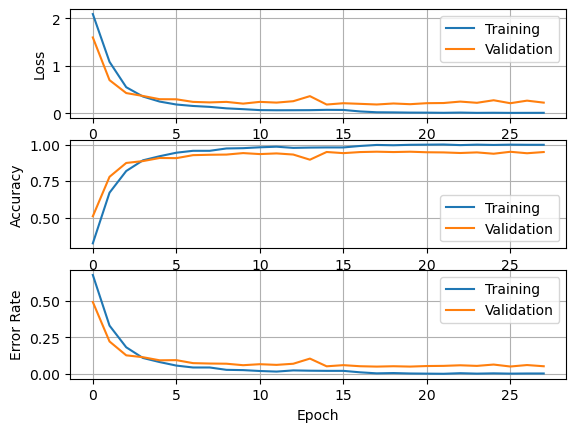

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Accuracy on training data: 0.998
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Accuracy on validation data: 0.9509166666666666
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy on testdata: 0.9565


<Figure size 640x480 with 0 Axes>

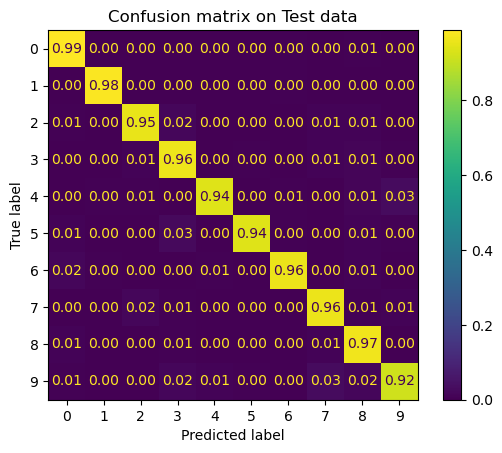

,Method,Training,Validation,Test
CNN,CNN,0.998,0.950917,0.9565


In [15]:
classi_weights_path_cnn = './pretrained/mnist_small_classifier_cnn.weights.h5'
classi_history_path_cnn = './pretrained/mnist_small_classifier_cnn.history.h5'

accuracies_cnn =  train_analyse_model(mnist_classifier_cnn, 'CNN', True, # train_from_scratch, 
                                       classi_weights_path_cnn, classi_history_path_cnn, 
                                       train_images, train_labels_OH, val_images, val_labels_OH, test_images, test_labels,
                                       nEpochs = 100, nPatience = 10)
accuracies_cnn

## Comparison with Plain Neural Network
Let's compare this with the neural network we used in the previous block (without convolutions):

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\andre\anaconda3\envs\CAS_DML\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


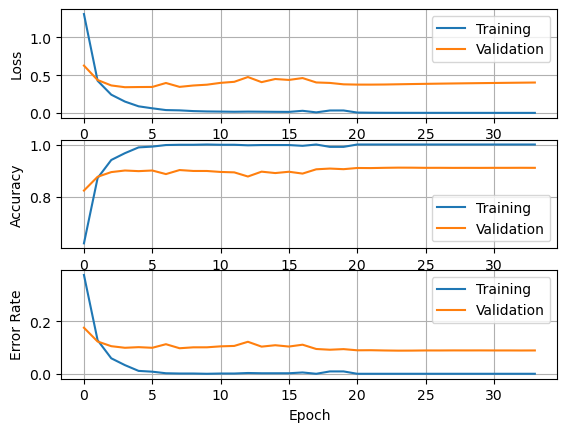

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Accuracy on training data: 1.0
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step

Accuracy on validation data: 0.91175
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
Accuracy on testdata: 0.9163


<Figure size 640x480 with 0 Axes>

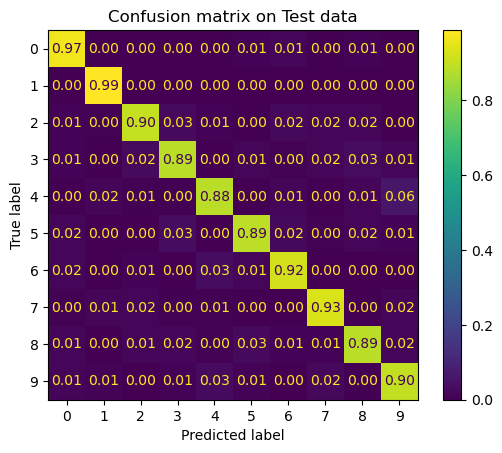

,Method,Training,Validation,Test
plain NN,plain NN,1.0,0.91175,0.9163


In [16]:
classi_weights_path_es = './pretrained/mnist_small_classifier_es.weights.h5'
classi_history_path_es = './pretrained/mnist_small_classifier_es.history.h5'

mnist_classifier_es = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

accuracies_es =  train_analyse_model(mnist_classifier_es, 'plain NN', False, 
                                       classi_weights_path_es, classi_history_path_es, 
                                       train_images, train_labels_OH, val_images, val_labels_OH, test_images, test_labels,
                                       nEpochs = 100, nPatience = 10)
accuracies_es

In [17]:
accuracies_df = pd.concat([accuracies_cnn, accuracies_es], axis=0)
accuracies_df_long = accuracies_df.melt(id_vars = 'Method')
accuracies_df_long.rename(columns={'variable': 'Dataset', 'value': 'Accuracy' }, inplace=True)
accuracies_df_long['Accuracy'] = 100*accuracies_df_long['Accuracy']
accuracies_df_long

,Method,Dataset,Accuracy
0,CNN,Training,99.800000
1,plain NN,Training,100.000000
2,CNN,Validation,95.091667
3,plain NN,Validation,91.175000
4,CNN,Test,95.650000
5,plain NN,Test,91.630000


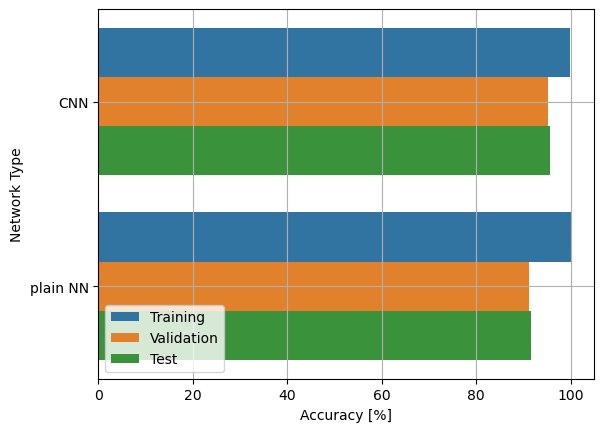

In [18]:
sns.barplot(data=accuracies_df_long, x='Accuracy', y='Method', hue='Dataset')
plt.legend(loc='lower left')
plt.grid()
plt.xlabel('Accuracy [%]')
plt.ylabel('Network Type')
plt.show()

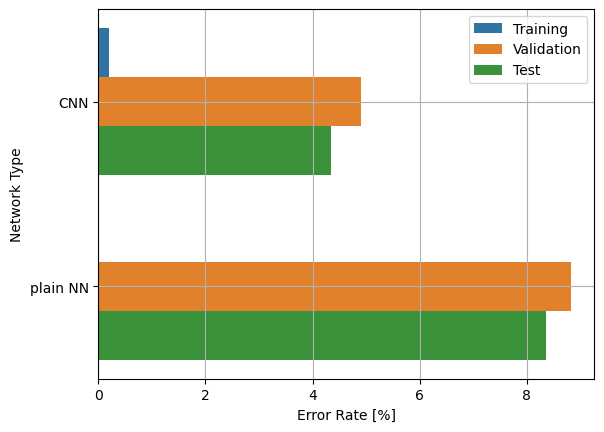

In [19]:
accuracies_df_long['Error Rate'] = 100-accuracies_df_long['Accuracy'] 

sns.barplot(data=accuracies_df_long, x='Error Rate', y='Method', hue='Dataset')
plt.legend()
plt.xlabel('Error Rate [%]')
plt.ylabel('Network Type')
plt.grid()
plt.show()